## Look at numerosity encoding at 2nd stimuli presentation

In [47]:
import os.path as op
import pandas as pd
import numpy as np

bids_folder = '/Users/mrenke/data/ds-dnumrisk'



In [48]:
from numrisk.utils.data import Subject

subject = 1
sub = Subject(subject, bids_folder=bids_folder)
session =1 

ims = sub.get_preprocessed_bold(session=session, runs=runs)


In [49]:
runs = range(1, 7)
onsets = sub.get_fmri_events(session=1, runs = runs) # np.shape(onsets)[0] = 2* N_trials !


In [50]:
# original
behavior = []
for run in runs:
    behavior.append(pd.read_table(op.join(
        sub.bids_folder, f'sub-{sub.subject}/ses-{session}/func/sub-{sub.subject}_ses-{session}_task-magjudge_run-{run}_events.tsv')))

behavior = pd.concat(behavior, keys=runs, names=['run'])
behavior = behavior.reset_index().set_index(
    ['run', 'trial_type'])


stimulus1 = behavior.xs('stimulus 1', 0, 'trial_type', drop_level=False).reset_index('trial_type')[['onset', 'trial_nr', 'trial_type']]
stimulus1['duration'] = 0.6
stimulus1['trial_type'] = stimulus1.trial_nr.map(lambda trial: f'trial_{trial:03d}_n1')


stimulus2 = behavior.xs('stimulus 2', 0, 'trial_type', drop_level=False).reset_index('trial_type')[['onset', 'trial_nr', 'trial_type', 'n2']]
stimulus2['duration'] = 0.6
stimulus2['trial_type'] = stimulus2.n2.map(lambda n2: f'n2_{int(n2)}')

events = pd.concat((stimulus1, stimulus2)).sort_index()

In [74]:
# new with n2 as trial type... ?

behavior = []
for run in runs:
    behavior.append(pd.read_table(op.join(
        sub.bids_folder, f'sub-{sub.subject}/ses-{session}/func/sub-{sub.subject}_ses-{session}_task-magjudge_run-{run}_events.tsv')))

behavior = pd.concat(behavior, keys=runs, names=['run'])
behavior = behavior.reset_index().set_index(
    ['run', 'trial_type'])
behavior = behavior[behavior['trial_nr'] != 0]

stimulus1 = behavior.xs('stimulus 1', 0, 'trial_type', drop_level=False).reset_index('trial_type')[['onset', 'trial_nr', 'trial_type', 'n1']]
stimulus1['duration'] = 0.6
stimulus1['trial_type'] = stimulus1.n1.map(lambda n1: f'n1_{int(n1)}')


stimulus2 = behavior.xs('stimulus 2', 0, 'trial_type', drop_level=False).reset_index('trial_type')[['onset', 'trial_nr', 'trial_type', 'n2']]
stimulus2['duration'] = 0.6
stimulus2['trial_type'] = stimulus2.trial_nr.map(lambda trial: f'trial_{trial:03d}_n2')

events = pd.concat((stimulus1, stimulus2)).sort_index()

In [77]:
from nilearn import image

#onsets = events
tr = 2.3
n = np.shape(image.load_img(ims[0]).get_fdata())[3] # number of volumes
frametimes = np.linspace(tr/2., (n - .5)*tr, n)
onsets['onset'] = ((onsets['onset']+tr/2.) // 2.3) * 2.3


In [81]:
from nilearn.glm.first_level import make_first_level_design_matrix
onsets = events[['onset', 'duration', 'trial_type']]

dm = [make_first_level_design_matrix(frametimes, onsets.loc[run], hrf_model='fir', oversampling=100.,
                                        drift_order=0,
                                        drift_model=None).drop('constant', axis=1) for run in runs]


/Users/mrenke/mambaforge/envs/numrefields/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `n2` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/Users/mrenke/mambaforge/envs/numrefields/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `n1` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/Users/mrenke/mambaforge/envs/numrefields/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `trial_nr` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/Users/mrenke/mambaforge/envs/numrefields/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `n2` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/Users/mrenke/

In [82]:
len(onsets.loc[1]['trial_type'].unique())

35

<AxesSubplot:label='conditions', ylabel='scan number'>

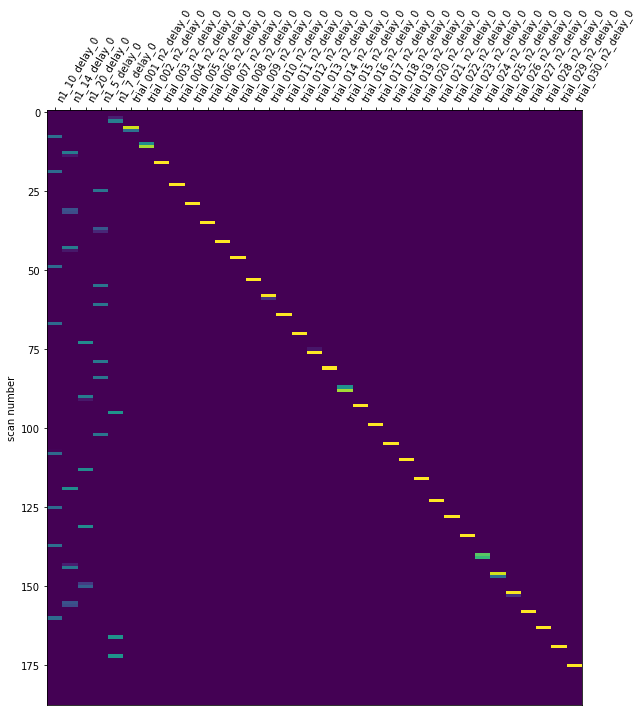

In [83]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(dm[0])

In [57]:
dm[0].shape # .columns

(188, 47)

In [84]:
dm = pd.concat(dm, keys=runs, names=['run']).fillna(0) # keys = range(1, 7)
dm.columns = [c.replace('_delay_0', '') for c in dm.columns]
dm /= dm.max()
#print(dm)
dm[dm < 1.0] = 0.0
print(dm.shape)

X = [dm.loc[run].values for run in runs]

print(len(X)) # 6 runs


/Users/mrenke/mambaforge/envs/numrefields/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `n2` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/Users/mrenke/mambaforge/envs/numrefields/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `n1` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/Users/mrenke/mambaforge/envs/numrefields/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `trial_nr` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/Users/mrenke/mambaforge/envs/numrefields/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `n2` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/Users/mrenke/

(1128, 185)
6


In [ ]:
data = [image.load_img(im).get_fdata() for im in ims]

opt = dict()
opt['wantlibrary'] = 1
opt['wantglmdenoise'] = 1
opt['wantfracridge'] = 1

# for the purpose of this example we will keep the relevant outputs in memory
# and also save them to the disk
opt['wantfileoutputs'] = [0, 0, 0, 1]

from glmsingle.glmsingle import GLM_single

# running python GLMsingle involves creating a GLM_single object
# and then running the procedure using the .fit() routine
glmsingle_obj = GLM_single(opt)

base_dir = 'glm_stim2.denoise'

results_glmsingle = glmsingle_obj.fit(
    X,
    data,
    0.6,
    2.3,
    outputdir=base_dir)

/Users/mrenke/mambaforge/envs/numrefields/lib/python3.10/site-packages/GLMsingle-0.0.1-py3.10.egg/glmsingle/utils/chunking.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(f)


*** FITTING TYPE-A MODEL (ONOFF) ***

fitting model...
done.

preparing output...
done.

computing model fits...
done.

computing R^2...


/Users/mrenke/mambaforge/envs/numrefields/lib/python3.10/site-packages/GLMsingle-0.0.1-py3.10.egg/glmsingle/cod/calc_cod.py:91: RuntimeWarning: overflow encountered in multiply
  return 100*f


done.

computing SNR...
done.



/Users/mrenke/mambaforge/envs/numrefields/lib/python3.10/site-packages/GLMsingle-0.0.1-py3.10.egg/glmsingle/ols/glm_estimatemodel.py:875: RuntimeWarning: divide by zero encountered in true_divide
  con = 1/np.abs(results['meanvol']) * 100
/Users/mrenke/mambaforge/envs/numrefields/lib/python3.10/site-packages/GLMsingle-0.0.1-py3.10.egg/glmsingle/ols/glm_estimatemodel.py:878: RuntimeWarning: invalid value encountered in multiply
  lambda x: x*con, 0, results['betas'])
/Users/mrenke/mambaforge/envs/numrefields/lib/python3.10/site-packages/GLMsingle-0.0.1-py3.10.egg/glmsingle/ols/glm_estimatemodel.py:880: RuntimeWarning: invalid value encountered in multiply
  lambda x: x*con, 0, results['betasmd'])
/Users/mrenke/mambaforge/envs/numrefields/lib/python3.10/site-packages/GLMsingle-0.0.1-py3.10.egg/glmsingle/ols/glm_estimatemodel.py:882: RuntimeWarning: invalid value encountered in multiply
  lambda x: x*con, 0, results['betasse'])


*** Setting brain R2 threshold to 0.10188412782204923 ***

*** FITTING TYPE-B MODEL (FITHRF) ***



chunks:   0%|          | 0/5 [00:00<?, ?it/s]/Users/mrenke/mambaforge/envs/numrefields/lib/python3.10/site-packages/GLMsingle-0.0.1-py3.10.egg/glmsingle/ols/glm_estimatemodel.py:875: RuntimeWarning: divide by zero encountered in true_divide
  con = 1/np.abs(results['meanvol']) * 100
/Users/mrenke/mambaforge/envs/numrefields/lib/python3.10/site-packages/GLMsingle-0.0.1-py3.10.egg/glmsingle/ols/glm_estimatemodel.py:878: RuntimeWarning: invalid value encountered in multiply
  lambda x: x*con, 0, results['betas'])
/Users/mrenke/mambaforge/envs/numrefields/lib/python3.10/site-packages/GLMsingle-0.0.1-py3.10.egg/glmsingle/ols/glm_estimatemodel.py:880: RuntimeWarning: invalid value encountered in multiply
  lambda x: x*con, 0, results['betasmd'])
/Users/mrenke/mambaforge/envs/numrefields/lib/python3.10/site-packages/GLMsingle-0.0.1-py3.10.egg/glmsingle/ols/glm_estimatemodel.py:882: RuntimeWarning: invalid value encountered in multiply
  lambda x: x*con, 0, results['betasse'])
/Users/mrenke/ma

*** DETERMINING GLMDENOISE REGRESSORS ***

*** CROSS-VALIDATING DIFFERENT NUMBERS OF REGRESSORS ***



chunks:   0%|          | 0/5 [00:00<?, ?it/s]/Users/mrenke/mambaforge/envs/numrefields/lib/python3.10/site-packages/GLMsingle-0.0.1-py3.10.egg/glmsingle/ssq/calcbadness.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  whcol = np.concatenate(np.asarray(validcolumns)[wh])
/Users/mrenke/mambaforge/envs/numrefields/lib/python3.10/site-packages/GLMsingle-0.0.1-py3.10.egg/glmsingle/ssq/calcbadness.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  testcols = np.asarray(validcolumns)[testix]
/Users/mrenke/mambaforge/envs/numrefields/lib/python3.10/si


*** FITTING TYPE-C MODEL (GLMDENOISE) ***



chunks:   0%|          | 0/5 [00:00<?, ?it/s]/Users/mrenke/mambaforge/envs/numrefields/lib/python3.10/site-packages/fracridge-2.0-py3.10.egg/fracridge/fracridge.py:193: RuntimeWarning: invalid value encountered in true_divide
  newlen = (newlen / newlen[0])
chunks:  20%|██        | 1/5 [00:05<00:22,  5.72s/it]/Users/mrenke/mambaforge/envs/numrefields/lib/python3.10/site-packages/fracridge-2.0-py3.10.egg/fracridge/fracridge.py:193: RuntimeWarning: invalid value encountered in true_divide
  newlen = (newlen / newlen[0])
chunks:  40%|████      | 2/5 [00:11<00:17,  5.71s/it]/Users/mrenke/mambaforge/envs/numrefields/lib/python3.10/site-packages/fracridge-2.0-py3.10.egg/fracridge/fracridge.py:193: RuntimeWarning: invalid value encountered in true_divide
  newlen = (newlen / newlen[0])
chunks:  60%|██████    | 3/5 [00:16<00:10,  5.20s/it]/Users/mrenke/mambaforge/envs/numrefields/lib/python3.10/site-packages/fracridge-2.0-py3.10.egg/fracridge/fracridge.py:193: RuntimeWarning: invalid value enc

*** FITTING TYPE-D MODEL (GLMDENOISE_RR) ***



chunks:   0%|          | 0/5 [00:00<?, ?it/s]/Users/mrenke/mambaforge/envs/numrefields/lib/python3.10/site-packages/fracridge-2.0-py3.10.egg/fracridge/fracridge.py:193: RuntimeWarning: invalid value encountered in true_divide
  newlen = (newlen / newlen[0])
/Users/mrenke/mambaforge/envs/numrefields/lib/python3.10/site-packages/fracridge-2.0-py3.10.egg/fracridge/fracridge.py:193: RuntimeWarning: invalid value encountered in true_divide
  newlen = (newlen / newlen[0])
/Users/mrenke/mambaforge/envs/numrefields/lib/python3.10/site-packages/fracridge-2.0-py3.10.egg/fracridge/fracridge.py:193: RuntimeWarning: invalid value encountered in true_divide
  newlen = (newlen / newlen[0])
/Users/mrenke/mambaforge/envs/numrefields/lib/python3.10/site-packages/fracridge-2.0-py3.10.egg/fracridge/fracridge.py:193: RuntimeWarning: invalid value encountered in true_divide
  newlen = (newlen / newlen[0])
/Users/mrenke/mambaforge/envs/numrefields/lib/python3.10/site-packages/fracridge-2.0-py3.10.egg/fracrid

In [39]:
results_glmsingle.keys()

dict_keys(['typea', 'typeb', 'typec', 'typed'])

In [43]:
type(results_glmsingle['typea']['betasmd'])

numpy.ndarray

In [36]:
betas = results_glmsingle['typed']['betasmd']
betas.shape # (59, 71, 49, 366) -- (x, y, z, n_volumes)

(59, 71, 49, 366)

In [37]:
betas = image.new_img_like(ims[0], betas) # Create a new image of the same class as the reference image.
betas.get_fdata().shape

(59, 71, 49, 366)

In [38]:
betas = image.index_img(betas, slice(None, None, 2))
betas.get_fdata().shape

(59, 71, 49, 183)

In [29]:
np.shape(data)

(6, 205261, 188)

In [ ]:
derivatives = op.join(bids_folder, 'derivatives')
base_dir = op.join(derivatives, base_dir, f'sub-{subject}', f'ses-{session}', 'func')
import os
os.makedirs(base_dir) if not op.exists(base_dir) else None

betas.to_filename(op.join(base_dir, f'sub-{subject}_ses-{session}_task-magjudge_space-T1w_desc-stims1_pe.nii.gz'))
